<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap5/BasicSkeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [55]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


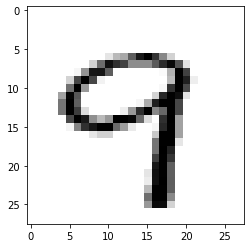

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape) # Each sample image is 28x28

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

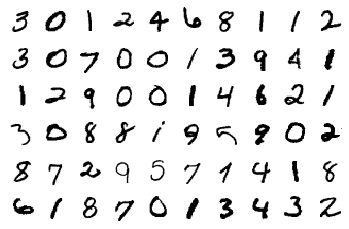

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0)
        ) 
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0)
        )
        self.maxpool_layer3 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv_layer4 = nn.Sequential(  
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0)
        )
        self.conv_layer5 = nn.Sequential(  
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0)
        )
        self.conv_layer6 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1)
        )
        self.conv_layer7 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0)
        )
        self.avgpool_layer8 = nn.AvgPool2d(kernel_size=6)
        self.conv_layer9 = nn.Sequential(  
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.conv_layer2(x)
        x = self.maxpool_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.avgpool_layer8(x)
        x = self.conv_layer9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [73]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
            Conv2d-2           [-1, 12, 24, 24]           1,308
         MaxPool2d-3           [-1, 12, 12, 12]               0
            Conv2d-4           [-1, 14, 10, 10]           1,526
            Conv2d-5             [-1, 16, 8, 8]           2,032
            Conv2d-6             [-1, 16, 8, 8]           2,320
            Conv2d-7             [-1, 16, 6, 6]           2,320
         AvgPool2d-8             [-1, 16, 1, 1]               0
            Conv2d-9             [-1, 10, 1, 1]             170
Total params: 9,796
Trainable params: 9,796
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.04
Estimated Total Size (MB): 0.20
------------------------------------------

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [74]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)







  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0








Loss=2.3065755367279053 Batch_id=0 Accuracy=9.38:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=2.3065755367279053 Batch_id=0 Accuracy=9.38:   0%|          | 1/469 [00:00<02:20,  3.34it/s]





Loss=2.3157081604003906 Batch_id=1 Accuracy=12.11:   0%|          | 1/469 [00:00<02:20,  3.34it/s]





Loss=2.3255319595336914 Batch_id=2 Accuracy=11.20:   0%|          | 1/469 [00:00<02:20,  3.34it/s]





Loss=2.3038477897644043 Batch_id=3 Accuracy=11.72:   0%|          | 1/469 [00:00<02:20,  3.34it/s]





Loss=2.2967629432678223 Batch_id=4 Accuracy=11.72:   0%|          | 1/469 [00:00<02:20,  3.34it/s]





Loss=2.2967629432678223 Batch_id=4 Accuracy=11.72:   1%|          | 5/469 [00:00<01:41,  4.58it/s]





Loss=2.3125908374786377 Batch_id=5 Accuracy=11.46:   1%|          | 5/469 [00:00<01:41,  4.58it/s]





Loss=2.309459686279297 Batch_id=6 Accuracy=11.05:   1%|          | 5/469 [00:00<01:41,  4.58it/s] 





Loss=2.304542303085327 Batch_id=7 Accuracy=11.33:   1%|          | 5


Test set: Average loss: 0.2367, Accuracy: 9254/10000 (92.54%)

EPOCH: 1








Loss=0.1345519721508026 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.1345519721508026 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.2875033915042877 Batch_id=1 Accuracy=92.97:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.24070334434509277 Batch_id=2 Accuracy=92.45:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.3829222321510315 Batch_id=3 Accuracy=91.41:   0%|          | 1/469 [00:00<01:58,  3.94it/s] 





Loss=0.3829222321510315 Batch_id=3 Accuracy=91.41:   1%|          | 4/469 [00:00<01:27,  5.30it/s]





Loss=0.1868423968553543 Batch_id=4 Accuracy=91.72:   1%|          | 4/469 [00:00<01:27,  5.30it/s]





Loss=0.2476380467414856 Batch_id=5 Accuracy=92.32:   1%|          | 4/469 [00:00<01:27,  5.30it/s]





Loss=0.1999283730983734 Batch_id=6 Accuracy=92.41:   1%|          | 4/469 [00:00<01:27,  5.30it/s]





Loss=0.21032612025737762 Batch_id=7 Accuracy=92.29:   1%|       


Test set: Average loss: 0.1519, Accuracy: 9519/10000 (95.19%)

EPOCH: 2








Loss=0.2849794924259186 Batch_id=0 Accuracy=89.84:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.2849794924259186 Batch_id=0 Accuracy=89.84:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.19735674560070038 Batch_id=1 Accuracy=91.80:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.15911580622196198 Batch_id=2 Accuracy=92.71:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.1874556541442871 Batch_id=3 Accuracy=92.97:   0%|          | 1/469 [00:00<01:58,  3.94it/s] 





Loss=0.2979872226715088 Batch_id=4 Accuracy=92.66:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.20306336879730225 Batch_id=5 Accuracy=92.71:   0%|          | 1/469 [00:00<01:58,  3.94it/s]





Loss=0.20306336879730225 Batch_id=5 Accuracy=92.71:   1%|▏         | 6/469 [00:00<01:25,  5.44it/s]





Loss=0.27378207445144653 Batch_id=6 Accuracy=92.19:   1%|▏         | 6/469 [00:00<01:25,  5.44it/s]





Loss=0.18600787222385406 Batch_id=7 Accuracy=92.58:   1%|▏  


Test set: Average loss: 0.1127, Accuracy: 9660/10000 (96.60%)

EPOCH: 3








Loss=0.19107189774513245 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.19107189774513245 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<01:55,  4.06it/s]





Loss=0.10688126087188721 Batch_id=1 Accuracy=94.92:   0%|          | 1/469 [00:00<01:55,  4.06it/s]





Loss=0.11259663105010986 Batch_id=2 Accuracy=95.57:   0%|          | 1/469 [00:00<01:55,  4.06it/s]





Loss=0.16077013313770294 Batch_id=3 Accuracy=95.31:   0%|          | 1/469 [00:00<01:55,  4.06it/s]





Loss=0.16077013313770294 Batch_id=3 Accuracy=95.31:   1%|          | 4/469 [00:00<01:24,  5.48it/s]





Loss=0.0780428946018219 Batch_id=4 Accuracy=95.78:   1%|          | 4/469 [00:00<01:24,  5.48it/s] 





Loss=0.13940170407295227 Batch_id=5 Accuracy=95.70:   1%|          | 4/469 [00:00<01:24,  5.48it/s]





Loss=0.16302865743637085 Batch_id=6 Accuracy=95.65:   1%|          | 4/469 [00:00<01:24,  5.48it/s]





Loss=0.28821316361427307 Batch_id=7 Accuracy=95.31:   1%|


Test set: Average loss: 0.1356, Accuracy: 9553/10000 (95.53%)

EPOCH: 4








Loss=0.13792942464351654 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.13792942464351654 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<01:55,  4.04it/s]





Loss=0.13191550970077515 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<01:55,  4.04it/s]





Loss=0.12827293574810028 Batch_id=2 Accuracy=95.57:   0%|          | 1/469 [00:00<01:55,  4.04it/s]





Loss=0.10699470341205597 Batch_id=3 Accuracy=95.70:   0%|          | 1/469 [00:00<01:55,  4.04it/s]





Loss=0.10699470341205597 Batch_id=3 Accuracy=95.70:   1%|          | 4/469 [00:00<01:25,  5.44it/s]





Loss=0.18811902403831482 Batch_id=4 Accuracy=95.16:   1%|          | 4/469 [00:00<01:25,  5.44it/s]





Loss=0.1165463924407959 Batch_id=5 Accuracy=95.31:   1%|          | 4/469 [00:00<01:25,  5.44it/s] 





Loss=0.23024600744247437 Batch_id=6 Accuracy=95.31:   1%|          | 4/469 [00:00<01:25,  5.44it/s]





Loss=0.14788344502449036 Batch_id=7 Accuracy=95.21:   1%|


Test set: Average loss: 0.0927, Accuracy: 9696/10000 (96.96%)

EPOCH: 5








Loss=0.15333972871303558 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.15333972871303558 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<01:59,  3.93it/s]





Loss=0.12919393181800842 Batch_id=1 Accuracy=95.31:   0%|          | 1/469 [00:00<01:59,  3.93it/s]





Loss=0.20479042828083038 Batch_id=2 Accuracy=94.79:   0%|          | 1/469 [00:00<01:59,  3.93it/s]





Loss=0.0629986822605133 Batch_id=3 Accuracy=95.51:   0%|          | 1/469 [00:00<01:59,  3.93it/s] 





Loss=0.1405254304409027 Batch_id=4 Accuracy=95.62:   0%|          | 1/469 [00:00<01:59,  3.93it/s]





Loss=0.012652266770601273 Batch_id=5 Accuracy=96.35:   0%|          | 1/469 [00:00<01:59,  3.93it/s]





Loss=0.012652266770601273 Batch_id=5 Accuracy=96.35:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s]





Loss=0.15398316085338593 Batch_id=6 Accuracy=95.98:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s] 





Loss=0.21124662458896637 Batch_id=7 Accuracy=95.70:   1


Test set: Average loss: 0.0914, Accuracy: 9708/10000 (97.08%)

EPOCH: 6








Loss=0.07865216583013535 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.07865216583013535 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:49,  4.28it/s]





Loss=0.03571612387895584 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<01:49,  4.28it/s]





Loss=0.13719019293785095 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<01:49,  4.28it/s]





Loss=0.11271052807569504 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<01:49,  4.28it/s]





Loss=0.1735195815563202 Batch_id=4 Accuracy=97.50:   0%|          | 1/469 [00:00<01:49,  4.28it/s] 





Loss=0.1735195815563202 Batch_id=4 Accuracy=97.50:   1%|          | 5/469 [00:00<01:19,  5.84it/s]





Loss=0.0356157049536705 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:19,  5.84it/s]





Loss=0.08699789643287659 Batch_id=6 Accuracy=97.54:   1%|          | 5/469 [00:00<01:19,  5.84it/s]





Loss=0.04246799647808075 Batch_id=7 Accuracy=97.66:   1%|  


Test set: Average loss: 0.0845, Accuracy: 9725/10000 (97.25%)

EPOCH: 7








Loss=0.27862152457237244 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.27862152457237244 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<01:32,  5.03it/s]





Loss=0.07265131175518036 Batch_id=1 Accuracy=95.31:   0%|          | 1/469 [00:00<01:32,  5.03it/s]





Loss=0.08475000411272049 Batch_id=2 Accuracy=95.83:   0%|          | 1/469 [00:00<01:32,  5.03it/s]





Loss=0.08475000411272049 Batch_id=2 Accuracy=95.83:   1%|          | 3/469 [00:00<01:12,  6.40it/s]





Loss=0.07940877974033356 Batch_id=3 Accuracy=96.09:   1%|          | 3/469 [00:00<01:12,  6.40it/s]





Loss=0.017867254093289375 Batch_id=4 Accuracy=96.88:   1%|          | 3/469 [00:00<01:12,  6.40it/s]





Loss=0.10520799458026886 Batch_id=5 Accuracy=96.88:   1%|          | 3/469 [00:00<01:12,  6.40it/s] 





Loss=0.09479755163192749 Batch_id=6 Accuracy=96.76:   1%|          | 3/469 [00:00<01:12,  6.40it/s]





Loss=0.09479755163192749 Batch_id=6 Accuracy=96.76:   1


Test set: Average loss: 0.0787, Accuracy: 9754/10000 (97.54%)

EPOCH: 8








Loss=0.08042364567518234 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.08042364567518234 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.11682229489088058 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.17025670409202576 Batch_id=2 Accuracy=96.35:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.10023999214172363 Batch_id=3 Accuracy=96.48:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.08054524660110474 Batch_id=4 Accuracy=96.72:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.04830310493707657 Batch_id=5 Accuracy=97.01:   0%|          | 1/469 [00:00<02:11,  3.57it/s]





Loss=0.04830310493707657 Batch_id=5 Accuracy=97.01:   1%|▏         | 6/469 [00:00<01:33,  4.93it/s]





Loss=0.11188407242298126 Batch_id=6 Accuracy=97.10:   1%|▏         | 6/469 [00:00<01:33,  4.93it/s]





Loss=0.10617056488990784 Batch_id=7 Accuracy=97.07:   1%|


Test set: Average loss: 0.0729, Accuracy: 9769/10000 (97.69%)

EPOCH: 9








Loss=0.029444299638271332 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.029444299638271332 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:47,  4.37it/s]





Loss=0.08920242637395859 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<01:47,  4.37it/s] 





Loss=0.06896655261516571 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<01:47,  4.37it/s]





Loss=0.06896655261516571 Batch_id=2 Accuracy=97.14:   1%|          | 3/469 [00:00<01:23,  5.56it/s]





Loss=0.1562516987323761 Batch_id=3 Accuracy=97.07:   1%|          | 3/469 [00:00<01:23,  5.56it/s] 





Loss=0.1781652271747589 Batch_id=4 Accuracy=96.88:   1%|          | 3/469 [00:00<01:23,  5.56it/s]





Loss=0.06526359170675278 Batch_id=5 Accuracy=97.27:   1%|          | 3/469 [00:00<01:23,  5.56it/s]





Loss=0.06526359170675278 Batch_id=5 Accuracy=97.27:   1%|▏         | 6/469 [00:00<01:03,  7.34it/s]





Loss=0.043225206434726715 Batch_id=6 Accuracy=97.43:   


Test set: Average loss: 0.0742, Accuracy: 9760/10000 (97.60%)

EPOCH: 10








Loss=0.02940092608332634 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.02940092608332634 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:47,  4.36it/s]





Loss=0.09978511184453964 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<01:47,  4.36it/s]





Loss=0.09978511184453964 Batch_id=1 Accuracy=98.05:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.05733275040984154 Batch_id=2 Accuracy=98.44:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.12509015202522278 Batch_id=3 Accuracy=97.66:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.05800101161003113 Batch_id=4 Accuracy=97.66:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.06542983651161194 Batch_id=5 Accuracy=97.40:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.16839437186717987 Batch_id=6 Accuracy=97.32:   0%|          | 2/469 [00:00<01:30,  5.15it/s]





Loss=0.06987245380878448 Batch_id=7 Accuracy=97.36:   0%|


Test set: Average loss: 0.0781, Accuracy: 9745/10000 (97.45%)

EPOCH: 11








Loss=0.06855420768260956 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.06855420768260956 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:01,  3.86it/s]





Loss=0.049653004854917526 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:01,  3.86it/s]





Loss=0.2362917959690094 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:01,  3.86it/s]  





Loss=0.05033859238028526 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:01,  3.86it/s]





Loss=0.15509319305419922 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<02:01,  3.86it/s]





Loss=0.15509319305419922 Batch_id=4 Accuracy=97.81:   1%|          | 5/469 [00:00<01:27,  5.29it/s]





Loss=0.07355037331581116 Batch_id=5 Accuracy=97.66:   1%|          | 5/469 [00:00<01:27,  5.29it/s]





Loss=0.09372268617153168 Batch_id=6 Accuracy=97.43:   1%|          | 5/469 [00:00<01:27,  5.29it/s]





Loss=0.05027196556329727 Batch_id=7 Accuracy=97.46:   1


Test set: Average loss: 0.0710, Accuracy: 9774/10000 (97.74%)

EPOCH: 12








Loss=0.021207354962825775 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.021207354962825775 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:09,  3.63it/s]





Loss=0.049518875777721405 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.63it/s] 





Loss=0.163955956697464 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:09,  3.63it/s]   





Loss=0.038542043417692184 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:09,  3.63it/s]





Loss=0.1339416354894638 Batch_id=4 Accuracy=97.66:   0%|          | 1/469 [00:00<02:09,  3.63it/s]  





Loss=0.11233051866292953 Batch_id=5 Accuracy=97.53:   0%|          | 1/469 [00:00<02:09,  3.63it/s]





Loss=0.07511502504348755 Batch_id=6 Accuracy=97.66:   0%|          | 1/469 [00:00<02:09,  3.63it/s]





Loss=0.07511502504348755 Batch_id=6 Accuracy=97.66:   1%|▏         | 7/469 [00:00<01:32,  5.02it/s]





Loss=0.04832921177148819 Batch_id=7 Accuracy=97.


Test set: Average loss: 0.0725, Accuracy: 9767/10000 (97.67%)

EPOCH: 13








Loss=0.04235221445560455 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.04235221445560455 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:36,  4.87it/s]





Loss=0.10631734132766724 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<01:36,  4.87it/s]





Loss=0.048416394740343094 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<01:36,  4.87it/s]





Loss=0.08505240082740784 Batch_id=3 Accuracy=97.27:   0%|          | 1/469 [00:00<01:36,  4.87it/s] 





Loss=0.08505240082740784 Batch_id=3 Accuracy=97.27:   1%|          | 4/469 [00:00<01:11,  6.48it/s]





Loss=0.09672193974256516 Batch_id=4 Accuracy=97.03:   1%|          | 4/469 [00:00<01:11,  6.48it/s]





Loss=0.20732110738754272 Batch_id=5 Accuracy=96.35:   1%|          | 4/469 [00:00<01:11,  6.48it/s]





Loss=0.09470582008361816 Batch_id=6 Accuracy=96.54:   1%|          | 4/469 [00:00<01:11,  6.48it/s]





Loss=0.047866299748420715 Batch_id=7 Accuracy=96.78:   


Test set: Average loss: 0.0756, Accuracy: 9754/10000 (97.54%)

EPOCH: 14








Loss=0.07237012684345245 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.07237012684345245 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:39,  4.72it/s]





Loss=0.10554962605237961 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<01:39,  4.72it/s]





Loss=0.0871279239654541 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<01:39,  4.72it/s] 





Loss=0.0871279239654541 Batch_id=2 Accuracy=97.40:   1%|          | 3/469 [00:00<01:17,  5.98it/s]





Loss=0.08280245214700699 Batch_id=3 Accuracy=97.27:   1%|          | 3/469 [00:00<01:17,  5.98it/s]





Loss=0.04982265457510948 Batch_id=4 Accuracy=97.66:   1%|          | 3/469 [00:00<01:17,  5.98it/s]





Loss=0.08844103664159775 Batch_id=5 Accuracy=97.66:   1%|          | 3/469 [00:00<01:17,  5.98it/s]





Loss=0.12094840407371521 Batch_id=6 Accuracy=97.54:   1%|          | 3/469 [00:00<01:17,  5.98it/s]





Loss=0.044758882373571396 Batch_id=7 Accuracy=97.75:   1%|


Test set: Average loss: 0.0670, Accuracy: 9789/10000 (97.89%)

EPOCH: 15








Loss=0.01398066058754921 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.01398066058754921 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:59,  3.92it/s]





Loss=0.11424872279167175 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<01:59,  3.92it/s] 





Loss=0.0111539326608181 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<01:59,  3.92it/s] 





Loss=0.1334429532289505 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<01:59,  3.92it/s]





Loss=0.035847365856170654 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<01:59,  3.92it/s]





Loss=0.0823354572057724 Batch_id=5 Accuracy=98.57:   0%|          | 1/469 [00:00<01:59,  3.92it/s]  





Loss=0.0823354572057724 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s]





Loss=0.052030015736818314 Batch_id=6 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:25,  5.40it/s]





Loss=0.018797412514686584 Batch_id=7 Accuracy=98.54: 


Test set: Average loss: 0.0705, Accuracy: 9772/10000 (97.72%)

EPOCH: 16








Loss=0.032720230519771576 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.032720230519771576 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:57,  3.99it/s]





Loss=0.03941475227475166 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:57,  3.99it/s] 





Loss=0.17426133155822754 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<01:57,  3.99it/s]





Loss=0.051586151123046875 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<01:57,  3.99it/s]





Loss=0.051586151123046875 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<01:26,  5.39it/s]





Loss=0.046219632029533386 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<01:26,  5.39it/s]





Loss=0.08560590445995331 Batch_id=5 Accuracy=97.66:   1%|          | 4/469 [00:00<01:26,  5.39it/s] 





Loss=0.09015855938196182 Batch_id=6 Accuracy=97.66:   1%|          | 4/469 [00:00<01:26,  5.39it/s]





Loss=0.0346401073038578 Batch_id=7 Accuracy=97.85:


Test set: Average loss: 0.0770, Accuracy: 9734/10000 (97.34%)

EPOCH: 17








Loss=0.11109347641468048 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.11109347641468048 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<01:49,  4.27it/s]





Loss=0.11647532135248184 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<01:49,  4.27it/s]





Loss=0.06930756568908691 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<01:49,  4.27it/s]





Loss=0.07211744040250778 Batch_id=3 Accuracy=96.88:   0%|          | 1/469 [00:00<01:49,  4.27it/s]





Loss=0.07211744040250778 Batch_id=3 Accuracy=96.88:   1%|          | 4/469 [00:00<01:21,  5.68it/s]





Loss=0.03346489742398262 Batch_id=4 Accuracy=97.19:   1%|          | 4/469 [00:00<01:21,  5.68it/s]





Loss=0.1059950441122055 Batch_id=5 Accuracy=97.14:   1%|          | 4/469 [00:00<01:21,  5.68it/s] 





Loss=0.06515651196241379 Batch_id=6 Accuracy=97.21:   1%|          | 4/469 [00:00<01:21,  5.68it/s]





Loss=0.16435730457305908 Batch_id=7 Accuracy=96.88:   1%|


Test set: Average loss: 0.0601, Accuracy: 9811/10000 (98.11%)

EPOCH: 18








Loss=0.024543490260839462 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.024543490260839462 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:54,  4.08it/s]





Loss=0.07608623802661896 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:54,  4.08it/s]  





Loss=0.04768649861216545 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<01:54,  4.08it/s]





Loss=0.05581529438495636 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<01:54,  4.08it/s]





Loss=0.1075049489736557 Batch_id=4 Accuracy=98.28:   0%|          | 1/469 [00:00<01:54,  4.08it/s] 





Loss=0.1075049489736557 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:23,  5.56it/s]





Loss=0.04657711461186409 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:23,  5.56it/s]





Loss=0.008135266602039337 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:23,  5.56it/s]





Loss=0.032380908727645874 Batch_id=7 Accuracy=98.63


Test set: Average loss: 0.0682, Accuracy: 9766/10000 (97.66%)

EPOCH: 19








Loss=0.07027332484722137 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]





Loss=0.07027332484722137 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<01:41,  4.63it/s]





Loss=0.03471537306904793 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<01:41,  4.63it/s]





Loss=0.09363412857055664 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<01:41,  4.63it/s]





Loss=0.12323194742202759 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<01:41,  4.63it/s]





Loss=0.12323194742202759 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<01:15,  6.19it/s]





Loss=0.05803826451301575 Batch_id=4 Accuracy=97.81:   1%|          | 4/469 [00:00<01:15,  6.19it/s]





Loss=0.06551113724708557 Batch_id=5 Accuracy=97.79:   1%|          | 4/469 [00:00<01:15,  6.19it/s]





Loss=0.21041801571846008 Batch_id=6 Accuracy=97.54:   1%|          | 4/469 [00:00<01:15,  6.19it/s]





Loss=0.06866494566202164 Batch_id=7 Accuracy=97.56:   1%|


Test set: Average loss: 0.0643, Accuracy: 9804/10000 (98.04%)



In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")